<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
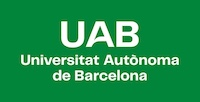
</div>
</div>
<div style="float: right; width: 50%;">
    <p style="margin: 0; padding-top: 22px; text-align:right;"><b>University Master's Degree in Computer Vision</b></p>
    <p style="margin: 0; text-align:right;">Reinforcement Learning</p>
    <p style="margin: 0; text-align:right;">Computer Vision Center (CVC)</p>
</div>
<div style="width: 100%; clear: both;"></div>
<div style="width:100%;">&nbsp;</div>

# Graph Neural Networks (GNN)

## 1. Data loading

The first step to solve this problem is, obviously, to load the data in _numpy_ array or _pandas_ dataframe.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
basepath = './'
basepath_data = os.path.join(basepath, 'data/')
basepath_results = os.path.join(basepath, 'results')

### Targets

According to the labels, people in this cohort are classified in four groups:
- **Healthy volunteers** (controls, _mstype = -1_): People without MS.
- **Relapsing remitting MS** (RRMS, _mstype = 0_) is a type of MS where you have relapses (symptoms getting worse) followed by recovery (that's when it's “remitting”). Your disability doesn't get worse between relapses but after each relapse it can end up worse than before.
- **Secondary progressive MS** (SPMS, _mstype = 1_) follows the initial course of relapsing-remitting MS (RRMS). Some people who are diagnosed with RRMS eventually go on to have a secondary progressive course, in which neurologic function worsens over time and disability increases.
- **Primary progressive MS** (PPMS, _mstype = 2_). If you have PPMS, you will experience gradually worsening neurologic symptoms and an accumulation of disability. You will not have relapses, or attacks, early in the disease course.

In [3]:
CT_CONTROL = -1
CT_RRMS = 0
CT_SPMS = 1
CT_PPMS = 2

The array target_class contains each mstype per patient.

In order to simplify the problem, we group all types of people in target array into:
- **Healthy volunteers** (HV), mstype == -1
- **People with MS** (pwMS), mstype == 0, 1, 2

In [4]:
target_class = np.load('data/target_class.npy')
target = np.load('data/target.npy')
print(target_class.shape, target.shape)

(270,) (270,)


Check the number of subjects in each category:

In [5]:
np.unique(target_class, return_counts=True)

(array([-1,  0,  1,  2]), array([ 71, 155,  31,  13]))

In [6]:
np.unique(target, return_counts=True)

(array([0, 1]), array([ 71, 199]))

### Data

The following data arrays contain a **3D _numpy_ array** to store only 'FA_thresholded' graphs. We don't really need ALL the data (all scans, prunes, etc.), just the FA_thresholded bc is the one that will give the graph structure. The others are just for node embeddings and we have those values sepparatedly.
- The shape of the array should be: _(num_subjects, num_nodes, num_nodes)_

where:
- "num_subjects" is 270,
- "nun_nodes" is 76 (parcellation scheme)

In [13]:
data = np.load("./data/FA_threshold.npy")
print("Data Shape      : {}".format(data.shape))  # Output: (270, 76, 76)
print("Min - Max values: {:.4f} - {:.4f}".format(np.min(data), np.max(data)))

Data Shape      : (270, 76, 76)
Min - Max values: 0.0000 - 0.7038


Check % of pwMS

In [15]:
prop = np.where(target == 1)[0].shape[0] / target.shape[0]
print("% of pwMS: {:.4f}".format(prop))

% of pwMS: 0.7370


### Node embeddings

Node features: cada node té associat:

- 3 tipus d'escàner (FA, GM, RS),
- cadascun amb 4 pruning (Original, kruskal, FakeKruskal, Threshold)
- que contenen 4 valors (degree, betweenness, clustering i randwalk)
- \+ 1 node volume
- = 3\*4\*4 + 1 = 49

x.shape == (num_nodes, num_node_features) on num_nodes = 76 i num_features = 49

**With** node volumes

The script for generating the node embeddings is in another file

In [16]:
# Load the embeddings matrix
node_embeddings = np.load(os.path.join(basepath_data, 'node_embeddings.npy'))
print(node_embeddings.shape)

(270, 76, 49)


## 2. Creating the data structures from adjacency matrices

The `array_to_graph` function creates a [Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html) structure from the DTI, GM and rs-fMRI adjacency matrices for each subject in the dataset.

The **input** parameter `data` should be an `np.array` of shape (76, 76) of adjacency matrices.

The **output** is `Data` object that contains a pseudo-graph, since edges from every layer are collapsed into this pseudo-graph. Thus, it is an extremely dense graph (probably, all possible edges exist in these graphs!).

In [17]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse


In [19]:
def array_to_graph(data, node_embeddings, y):
    """
    Convert a dense NumPy adjacency matrix into a PyTorch Geometric Data object,
    incorporating node embeddings.

    Args:
    - data: NumPy array of shape (num_nodes, num_nodes), adjacency matrix.
    - node_embeddings: NumPy array of shape (num_nodes, num_features), node embeddings.
    - y: Target label (scalar or one-hot).

    Returns:
    - PyTorch Geometric Data object.
    """
    # Convert the dense adjacency matrix to a PyTorch tensor
    adj_tensor = torch.tensor(data, dtype=torch.float)
    
    # Convert dense tensor to edge_index and edge_weight
    edge_index, edge_weight = dense_to_sparse(adj_tensor)
    
    # Convert node embeddings to a PyTorch tensor
    x = torch.tensor(node_embeddings, dtype=torch.float)
    
    # Create the target label tensor
    y = torch.tensor([int(y)], dtype=torch.long)  # Classification target
    
    # Construct the PyTorch Geometric Data object
    graph_data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)
    
    return graph_data


## 3. Defining the Graph Convolutional Network (GCN)

The `GCN` class defines:
1. The class constructor
2. The `forward` method defines the computation performed at every call.

In [20]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_max_pool

class GCN(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, 128)
        self.lin1 = torch.nn.Linear(128, 64)
        self.lin2 = torch.nn.Linear(64, 16)
        self.lin3 = torch.nn.Linear(16, 2)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_weight, data.batch
        
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = global_max_pool(x, batch)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)

        return x

In this example, we use the CPU to perform the training (it will last for WAY LESS THAN 5–10 minutes).

In [21]:
device = torch.device('cpu')

## 4. Training loop

This is the main training loop, where:
1. We define the $k$-fold cross-validation (`StratifiedKFold`)
2. For each fold:
  - Create the model, optimizer, and loss function.
  - Load the train dataset in `DataLoader` and define the batches.
  - Execute the forward and backward steps
3. Load the test dataset in `DataLoader` and define the batches.
4. Test the model and compute the performance metrics.

Anar **guardant els resultats** en fitxers en una carpeta anomenada "results".

In [27]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Format the current time as a string (e.g., "2024-12-11_14-30-00")
filename = current_time.strftime("%Y%m%d_%H%M%S") + ".txt"
filepath = os.path.join(basepath, "results/" + filename)

# Create and write to the file
with open(filepath, "w") as file:
    file.write(f'Model trained on {current_time.strftime("%Y %m %d %H:%M:%S")}.\n')

In [29]:
num_folds = 5

In [30]:
# Save parameters of model
with open(filepath, "a") as file:
        file.write("Data normal.\n")
        file.write(f"stratifiedKfold; {num_folds} folds.\n")
        file.write("Node embeddings dimension: 49.\n")
        file.write("1 conv layer (49, 128) + 3 lin layer (128, 64), (64, 16), (16, 2).\n\n")

In [31]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import torch.nn as nn

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

NUM_EPOCHS = 100
preds = np.zeros(data.shape[0])
fold = 0

for train_index, test_index in skf.split(data, target):
    fold += 1
    print("Fold: {}".format(fold))

    # split dataset
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = target[train_index], target[test_index]
    embed_train, embed_test = node_embeddings[train_index], node_embeddings[test_index]
    
    prop_train = np.where(y_train == 1)[0].shape[0] / y_train.shape[0]
    prop_test = np.where(y_test == 1)[0].shape[0] / y_test.shape[0]
    print("Train set size     : {}".format(X_train.shape))
    print("Test set size      : {}".format(X_test.shape))
    print("Train set % of pwMS: {:.4f} ({})".format(prop_train, y_train.sum()))
    print("Test set % of pwMS : {:.4f} ({})".format(prop_test, y_test.sum()))

    # list of Data structures (one for each subject)
    train_graphs = []
    for i in range(X_train.shape[0]):
        g = array_to_graph(X_train[i], embed_train[i], y_train[i])
        train_graphs.append(g)
        
    test_graphs = []
    for i in range(X_test.shape[0]):
        g = array_to_graph(X_test[i], embed_test[i], y_test[i])
        test_graphs.append(g)

    # create the model
    input_dim = node_embeddings.shape[2]
    model = GCN(input_dim)
    model = model.to(device)
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    # Custom loss function to penalise false negatives
    #class_weights = torch.tensor([1.0, 1.0]).to(device) # Higher weight for minority class 0 (negative class)
    #loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # train function
    def train():
        model.train()
        
        train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)

        loss_all = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            label = batch.y
            label = F.one_hot(label, num_classes=2)
            label = label.type(torch.FloatTensor)
            label = label.to(device)
            loss = loss_fn(output, label)
            loss.backward()
            loss_all += batch.num_graphs * loss.item()
            optimizer.step()

        return loss_all / len(train_graphs)

    # train for N epochs
    for epoch in range(NUM_EPOCHS):
        loss_value = train()
        print("Train loss at epoch {}: {:.4f}".format(epoch + 1, loss_value))

    # test phase 
    test_loader = DataLoader(test_graphs, batch_size=len(test_graphs), shuffle=False)
    
    for batch in test_loader:
        batch = batch.to(device)
        test_preds = F.softmax(model(batch), dim=1).detach().numpy()
    

    # Collect predictions and true labels
    all_preds = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            # Get the predicted class (highest probability)
            preds_eval = torch.argmax(F.softmax(output, dim=1), dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()  # True labels
            all_preds.extend(preds_eval)
            all_labels.extend(labels)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)


    test_preds = test_preds[:, 1]
    preds[test_index] = test_preds
    
    auc_roc = roc_auc_score(y_test, test_preds)
    print("Test AUC: {:.2f}".format(auc_roc))

    # Open the text file in append mode (this will add to the file without overwriting)
    with open(filepath, "a") as file:
        file.write(f"Fold: {fold}\n")
        file.write("Train set size     : {}\n".format(X_train.shape))
        file.write("Test set size      : {}\n".format(X_test.shape))
        file.write("Train set % of pwMS: {:.4f} ({})\n".format(prop_train, y_train.sum()))
        file.write("Test set % of pwMS : {:.4f} ({})\n".format(prop_test, y_test.sum()))
        file.write("Confusion Matrix:\n{}\n".format(conf_matrix))
        file.write("Test AUC: {:.2f}\n\n".format(auc_roc))


Fold: 1
Train set size     : (216, 76, 76)
Test set size      : (54, 76, 76)
Train set % of pwMS: 0.7361 (159)
Test set % of pwMS : 0.7407 (40)
Train loss at epoch 1: 0.7198
Train loss at epoch 2: 0.6334
Train loss at epoch 3: 0.5611
Train loss at epoch 4: 0.5600
Train loss at epoch 5: 0.5573
Train loss at epoch 6: 0.5432
Train loss at epoch 7: 0.5393
Train loss at epoch 8: 0.5348
Train loss at epoch 9: 0.5261
Train loss at epoch 10: 0.5194
Train loss at epoch 11: 0.5134
Train loss at epoch 12: 0.5046
Train loss at epoch 13: 0.4979
Train loss at epoch 14: 0.4900
Train loss at epoch 15: 0.4824
Train loss at epoch 16: 0.4757
Train loss at epoch 17: 0.4738
Train loss at epoch 18: 0.4612
Train loss at epoch 19: 0.4545
Train loss at epoch 20: 0.4530
Train loss at epoch 21: 0.4392
Train loss at epoch 22: 0.4379
Train loss at epoch 23: 0.4348
Train loss at epoch 24: 0.4272
Train loss at epoch 25: 0.4204
Train loss at epoch 26: 0.4123
Train loss at epoch 27: 0.4086
Train loss at epoch 28: 0.40

Finally, we compute the **AUC-ROC**, **AUC-PR** and **accuracy** metrics to test the performance of the model.

In [32]:
auc_roc = roc_auc_score(target, preds)
auc_pr = average_precision_score(target, preds)
    
best_acc = 0
best_th = 0
for th in preds:
    acc = accuracy_score(target, (preds >= th).astype(int))
    if acc >= best_acc:
        best_acc = acc
        best_th = th
        
print("")
prop = np.where(target == 1)[0].shape[0] / target.shape[0]
print("% of pwMS: {:.4f}".format(prop))
print("AUC ROC  : {:.4f}".format(auc_roc))
print("AUC PR   : {:.4f}".format(auc_pr))
print("ACC      : {:.4f}".format(best_acc))

# Open the text file in append mode (this will add to the file without overwriting)
with open(filepath, "a") as file:
    file.write("% of pwMS: {:.4f}\n".format(prop))
    file.write("AUC ROC  : {:.4f}\n".format(auc_roc))
    file.write("AUC PR   : {:.4f}\n".format(auc_pr))
    file.write("ACC      : {:.4f}\n\n".format(best_acc))


% of pwMS: 0.7370
AUC ROC  : 0.8058
AUC PR   : 0.9230
ACC      : 0.7963


Confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

# Test phase
test_loader = DataLoader(test_graphs, batch_size=len(test_graphs), shuffle=False)

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = model(batch)
        # Get the predicted class (highest probability)
        preds_eval = torch.argmax(F.softmax(output, dim=1), dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()  # True labels
        all_preds.extend(preds_eval)
        all_labels.extend(labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Confusion Matrix:
[[ 6  9]
 [ 5 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.40      0.46        15
           1       0.79      0.87      0.83        39

    accuracy                           0.74        54
   macro avg       0.67      0.64      0.65        54
weighted avg       0.72      0.74      0.73        54



## 5. Results

We plot the **ROC Curve** and **Precision Recall Curve** to analyse the performance of the model.

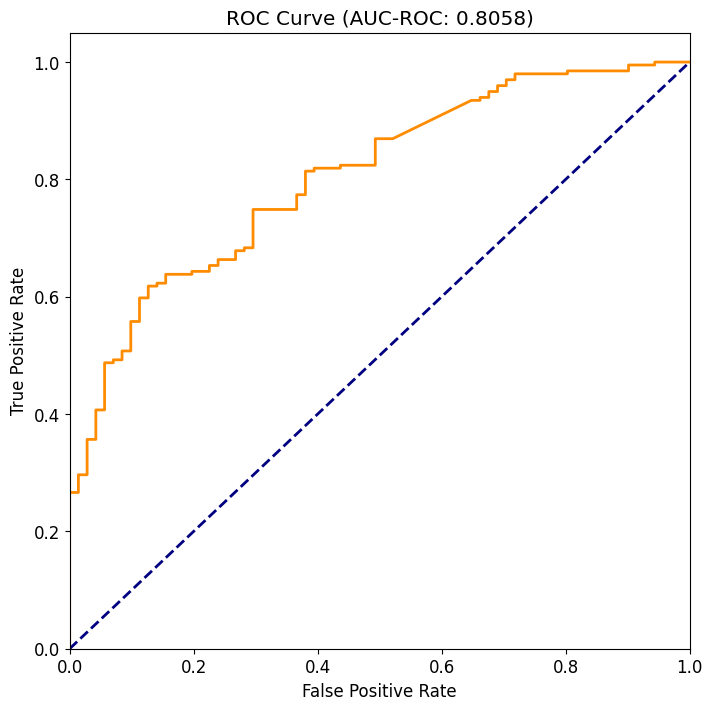

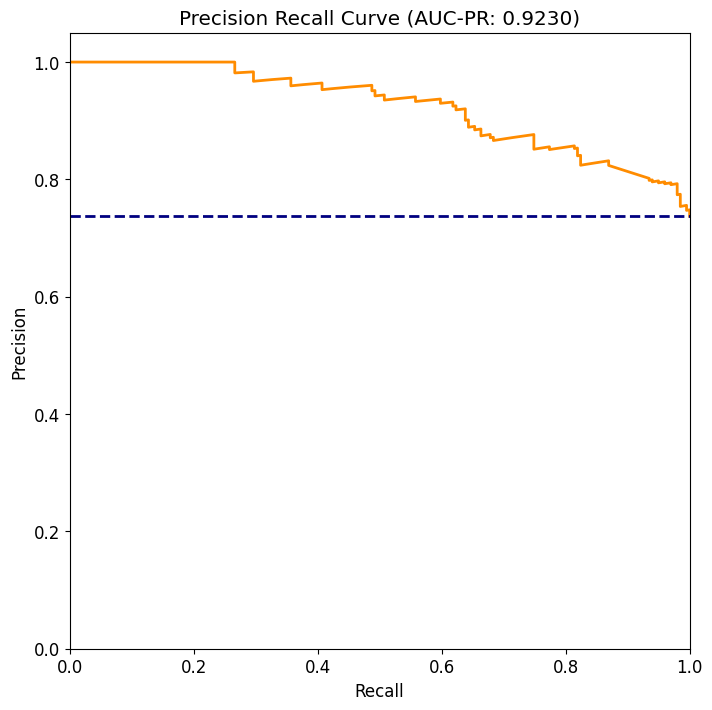

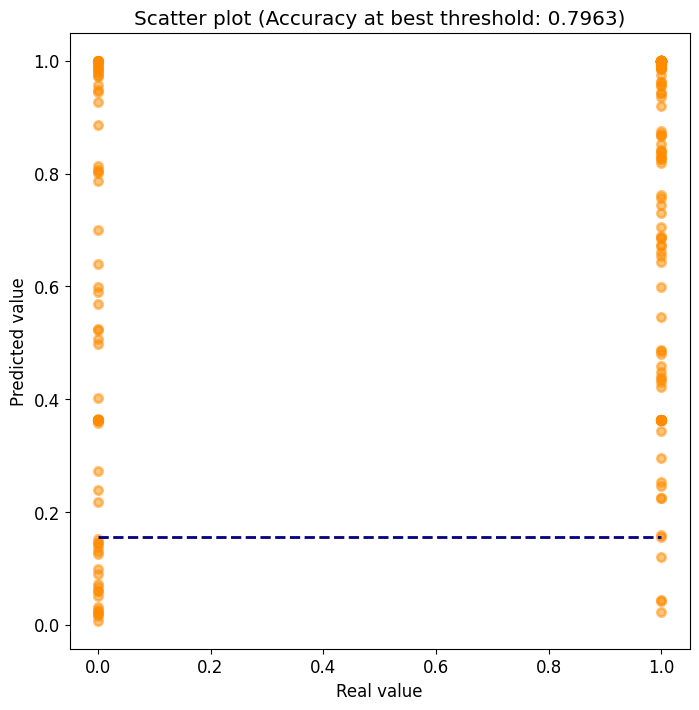

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12


# compute AUC-ROC and ROC curve
auc_roc = roc_auc_score(target, preds)
fpr, tpr, ths = roc_curve(target, preds)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AUC-ROC: {:.4f})".format(auc_roc))
plt.savefig("./results/" + current_time.strftime("%Y%m%d_%H%M%S") + "_ROC_" + ".png")
plt.show()

# Compute AUC-PR
auc_pr = average_precision_score(target, preds)
prec, recall, ths = precision_recall_curve(target, preds)

plt.figure()
lw = 2
plt.plot(recall, prec, color="darkorange", lw=lw)
plt.plot([0, 1], [prop, prop], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve (AUC-PR: {:.4f})".format(auc_pr))
plt.savefig("./results/" + current_time.strftime("%Y%m%d_%H%M%S") + "_PrRec_" + ".png")
plt.show()

# Compute ACC and threshold
best_acc = 0
best_th = 0
for th in ths:
    acc = accuracy_score(target, (preds >= th).astype(int))
    if acc >= best_acc:
        best_acc = acc
        best_th = th

plt.figure()
plt.scatter(target, preds, alpha=0.5, color="darkorange", lw=lw)
plt.plot([0, 1], [best_th, best_th], color='navy', lw=lw, linestyle='--')
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.title("Scatter plot (Accuracy at best threshold: {:.4f})".format(best_acc))
plt.savefig("./results/" + current_time.strftime("%Y%m%d_%H%M%S") + "_scatt_" + ".png")
plt.show()